# NE 630 - Lesson 37

**LAST TIME**:  The two-group criticality problem.

**TODAY**: The reflected reactor.

**NEXT TIME**:  Modeling reactor control (and control "worth").

# Review: The Bare Slab Reactor

Consider a slab reactor of width $a$, for which the one-group diffusion equation is

$$
   \frac{d^2 \phi}{dx^2} + \overbrace{\frac{k_{\infty}/k-1}{L^2}}^{B^2} = 0 
    \quad \longrightarrow \quad \phi(x) = C_1 \cos(Bx) \, .
$$


For zero-flux conditions, we have

$$
  B^2 = \left ( \frac{\pi}{a} \right )^2
$$

For extrapolated-flux conditions (with $\lambda = 1/\Sigma_{tr} = 3D$), we have 

$$
   B^2 = \left ( \frac{\pi/2}{\frac{a}{2}+\frac{2\lambda}{3}} \right )^2 = \left ( \frac{\pi}{a+4D} \right )^2
$$

For vacuum conditions, we found the transcendental equation

$$
 \boxed{ \cot{\frac{Ba}{2}} = 2BD } \, .
 \tag{criticality condition}
$$

Given $B^2$, it we have

$$
   k = \frac{k_{\infty}}{1+L^2 B^2} \, .
$$ 

In [1]:
import numpy as np
D = 1.0; Σ_a = 0.1; a = 50;  L = np.sqrt(D/Σ_a); λ = 3*D;  k_oo = 1.3;

In [2]:
B_squared = (np.pi/a)**2;   k = k_oo / (1+L**2*B_squared);
print(f"B^2 = {B_squared:.5f}   k = {k:.5f}")

B^2 = 0.00395   k = 1.25063


In [3]:
B_squared = (np.pi/(a+4*D))**2;   k = k_oo / (1+L**2*B_squared);
print(f"B^2 = {B_squared:.6f}   k = {k:.5f}")

B^2 = 0.003385   k = 1.25744


In [4]:
cot = lambda x: np.cos(x)/np.sin(x)
f = lambda B: cot(B*a/2)-2*B*D
from scipy.optimize import fsolve
B = fsolve(f, np.pi/a)[0]
B_squared = B**2;   k = k_oo / (1+L**2*B_squared);
print(f"B^2 = {B_squared:.6f}   k = {k:.5f}")

B^2 = 0.003387   k = 1.25741


In other words, the extrapolated flux condition is only *approximating* the vacuum condition!

# The Reflected Reactor 

The idea is simple: replace the vacuum with something that causes neutrons to scatter back into the reactor.

A good reflector has a **small $\Sigma_a$** and **large $\Sigma_s$**. 

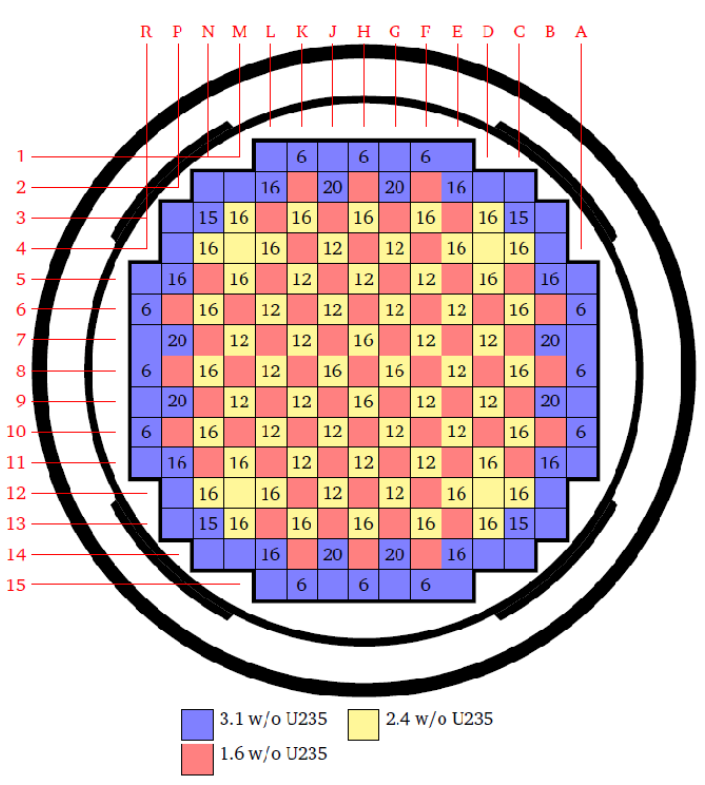

[Diagram from the MIT BEAVRS Benchmark Specification (based on a commercial PWR)]

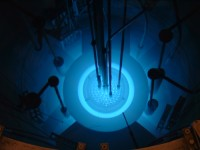

[K-State TRIGA]

# Example:  The Reflected Slab

In the fuel region (call that region I), nothing changes:

$$
  \phi_{I}(x) = C_1 \cos(Bx) \, .
$$

In the reflector region, there is no fission, so $-\phi_{II}'' + (1/L^2)\phi_{II}(x) = 0$ and

$$
 \phi_{II}(x) = C_2 \cosh(x/L) + C_3 \sinh(x/L) \, .
$$

In [5]:
import sympy as sy
D_I, D_II, Sigma_a, a, t, B, L = sy.symbols("D_I, D_II, Sigma_a, a, t, B, L_II", positive=True)
C1, C2, C3 = sy.symbols("C1, C2, C3")
x = sy.symbols("x", real=True)
phi_I = C1*sy.cos(B*x)
phi_II = C2*sy.cosh(x/L) + C3*sy.sinh(x/L)

First, we apply the outer boundary condition (assuming vacuum) so that

$$
  \frac{\phi_{II}(a/2+t)}{4} + \frac{D_{II}}{2} \frac{d\phi_{II}}{dx} \Big |_{x=a/2+t} = 0 \, . 
$$

In [6]:
bc = sy.Eq( phi_II.subs(x, a/2+t)/4 + (D_II/2)*sy.diff(phi_II, x).subs(x, a/2+t), 0)
bc 

Eq(C2*cosh((a/2 + t)/L_II)/4 + C3*sinh((a/2 + t)/L_II)/4 + D_II*(C2*sinh((a/2 + t)/L_II)/L_II + C3*cosh((a/2 + t)/L_II)/L_II)/2, 0)

Then, we can eliminate one of the coefficients:

In [7]:
coefs = sy.solve([bc], C2)

In [8]:
coefs[C2].simplify()

-C3*(2*D_II*cosh((a/2 + t)/L_II) + L_II*sinh((a/2 + t)/L_II))/(2*D_II*sinh((a/2 + t)/L_II) + L_II*cosh((a/2 + t)/L_II))

Now, our reflector flux depends only on $C_3$:

In [9]:
phi_II_sol = phi_II.subs(coefs).simplify()
phi_II_sol

-C3*(2*D_II*cosh((a/2 + t - x)/L_II) + L_II*sinh((a/2 + t - x)/L_II))/(2*D_II*sinh((a/2 + t)/L_II) + L_II*cosh((a/2 + t)/L_II))

Remember, **SymPy is being used here only for algebra**!

Now, the continuity conditions:

$$
   \phi_I(a/2) = \phi_{II}(a/2)
   \tag{flux continuity}
$$

and 

$$
  -D_I\phi_I'(a/2) = -D_{II} \phi_{II}'(a/2) \, .
  \tag{current continuity}
$$


The trick:  note that both fluxes have an arbitrary constant ($C_1$ and $C_3$).  So, we can divide the current continuity equation by the flux continuity equation to get a new criticality condition:

In [10]:
LHS = (sy.diff(D_I*phi_I, x)/phi_I).subs(x, a/2).simplify() 
LHS

-B*D_I*tan(B*a/2)

In [11]:
RHS = (sy.diff(D_II*phi_II_sol, x)/phi_II_sol).subs(x, a/2).simplify()

In [12]:
criticality_condition = sy.Eq(LHS, RHS)
criticality_condition 

Eq(-B*D_I*tan(B*a/2), -D_II*(2*D_II*sinh(t/L_II) + L_II*cosh(t/L_II))/(L_II*(2*D_II*cosh(t/L_II) + L_II*sinh(t/L_II))))

In the limit that the reflector is infinitely thick, we have

In [13]:
criticality_condition = sy.Eq(LHS, sy.limit(RHS, t, sy.oo))
criticality_condition

Eq(-B*D_I*tan(B*a/2), -D_II/L_II)

This is equivalent to Eq. (7.69) in the text (with $\alpha^2 = 1/L_{II}^2$).  Solving for $a$ yields

In [14]:
sy.Eq(a, sy.solve(criticality_condition, a)[0])

Eq(a, 2*atan(D_II/(B*D_I*L_II))/B)

## Example

Suppose our two-region data is as entered below (where the region I data is the same as our initial bare reactor material).  How wide must the reflected reactor be to have the same multiplication as the bare core assuming an infinitely thick reflector?

In [15]:
import numpy as np
D_I = 1.0; Σ_a_I = 0.1; a = 50;  L_I = np.sqrt(D_I/Σ_a_I); k_oo = 1.3;
D_II = 0.9; Σ_a_II = 0.01; L_II = np.sqrt(D_II/Σ_a_II); 
B_bare = np.sqrt(0.003387)

In [16]:
a_prime = np.arctan(D_II/(B_bare*D_I*L_II))/B_bare
print(f"a' = {a_prime:.4f} cm")

a' = 17.5356 cm


## Summary

For our **bare** reactor, we needed to satisfy the criticality condition

$$
  \cot{\frac{Ba}{2}} = 2BD_I  \, .
$$

and for $D_I = 1$ cm, $\Sigma_a = 0.1$ 1/cm, $k_{\infty} = 1.3$, and $a = 50$ cm, we found

$$
B^2 = 0.003387 \qquad \text{and} \qquad  k = 1.25741 \, .
$$

For the **reflected** reactor (with an *infinitely thick reflector*), the modified criticality condition is

$$
  a' = \frac{2 \operatorname{atan}{\left(\frac{D_{II}}{B D_{I} L_{II}} \right)}}{B}
$$

where $a'$ is the width of the reflected reactor, and for the same values

The key point: $a' = 17.5356$ cm is *much less than* $a = 50$ cm for the same value of $B^2$ (and, hence, $k$).

The book defines the **reflector savings** specifically as $\delta_x = (1/2)(a-a')$, so our savings would be

In [17]:
print(f"reflector savings = {0.5*(a-a_prime):.4f} cm")

reflector savings = 16.2322 cm
